In [1]:
from math import log2
from sage.misc.sage_timeit import sage_timeit
from cryptographic_estimators.SDEstimator import SDEstimator 

def sgbp_lower_bound(n, k):
    if 2**k >= n:
        return 2**k + n
    else:
        return 2**k * 2**(n/(2**k))
        
def lgbp_lower_bound(n = 288, k = 2, pow2 = True):
    if pow2:
        K = 2**k
    else:
        K = k
    if K >= 2**20:
        st = K + n//log(K,2)
        while binomial(st, st - K) < 2**n:
            st += 1
        return st
    st = n//K
    while binomial(2**st, K) < 2**n:
        st += 1
    if binomial(2**st, K) == 2**n:
        return 2**st
    # binary search
    ub = 2**(st)
    lb = 2**(st - 1)
    while lb + 1 < ub:
        mid = (ub + lb) // 2
        total = binomial(mid, K)
        if total < 2**n:
            lb = mid
        elif total > 2**n:
            ub = mid
        else:
            return mid
    assert binomial(lb, K) < 2**n
    assert binomial(ub, K) >= 2**n
    return ub
    
def k_list_time_estimator(n, k):
    # Wagner's algorithm for SGBP(n, K=2^k)
    # ell = ceil(n/(k + 1))
    ell = n/(k + 1)
    # the time complexity of Wagner's algorithm should be 2^{ell + k + 1} instead of 2^{ell + k},
    return (2^k - 1) * 2^(1 + ell)

def k_list_mem_estimator(n, k):
    # Wagner's algorithm for SGBP(n, K=2^k)
    # ell = ceil(n/(k + 1))
    ell = n/(k + 1)
    N = 2^(ell + 1)
    return (k + 4)*n*N/4 + (2^k - 1)*ell*N/2

def approx_expected_sol(n, k):
    ell = n/(k+1)
    N = 2^(ell + 1)
    # make sure 2**k << N, at least : k < ell + 1
    return RR(2 * e**(-(2^(2*k) - 2^k)/(2*N)))

def single_list_time_estimator(n, k):
    # ell = ceil(n /(k+1))
    ell = n/(k+1)
    N = 2^(ell + 1)
    return k * N

def single_list_mem_estimator(n, k):
    # ell = ceil(n /(k+1))
    ell = n/(k+1)
    N = 2^(ell + 1)
    return 2*(n + k - ell - 1) * N
    
def single_list_k_upper_bound(n):
    return sqrt(n/2 + 1)


In [2]:
# iSHAKE Analysis
from collections import namedtuple
iSHAKE = namedtuple("iSHAKE", ['N', 'kmin', 'kmax'])
iSHAKE128 = iSHAKE(N=2^25, kmin = 2688, kmax = 4160)
iSHAKE256 = iSHAKE(N=2^28, kmin = 6528, kmax = 16512)

# estimate the proposed parameters with bounded block number < N
print("Estimate iSHAKE128 with limited block number i.e. < N")
T_sgbp = k_list_time_estimator(iSHAKE128.kmin, int(log(iSHAKE128.N, 2)))
T_lgbp = single_list_time_estimator(iSHAKE128.kmin, int(log(iSHAKE128.N, 2)))
expected_sol = approx_expected_sol(iSHAKE128.kmin, int(log(iSHAKE128.N, 2)))
print(f"The proposed security strength: {RR(log(T_sgbp, 2))}")
print(f"The security strength in our work: {RR(log(T_lgbp, 2))} with {expected_sol = }")
print()

print("Estimate iSHAKE128 with unlimited block number, the low bound security of iSHAKE128")
sgbp_upper_k = round(sqrt(iSHAKE128.kmax) - 1)
lgbp_upper_k = floor(single_list_k_upper_bound(iSHAKE128.kmax))
print(f"The best parameter of k in SGBP {sgbp_upper_k}")
print(f"The best parameter of k in SGBP {lgbp_upper_k} with ell = {ceil(iSHAKE128.kmax /(lgbp_upper_k+1))}")
T_sgbp = k_list_time_estimator(iSHAKE128.kmax, sgbp_upper_k)
T_lgbp = single_list_time_estimator(iSHAKE128.kmax, lgbp_upper_k)
expected_sol = approx_expected_sol(iSHAKE128.kmax, lgbp_upper_k)
print(f"The proposed low bound security: {RR(log(T_sgbp, 2))}")
print(f"The low bound security in our work: {RR(log(T_lgbp, 2))} with {expected_sol = }")
print()

# estimate the proposed parameters with bounded block number < N
print("Estimate iSHAKE256 with limited block number i.e. < N")
n = iSHAKE256.kmin
k = int(log(iSHAKE256.N, 2))
T_sgbp = k_list_time_estimator(n, k)
T_lgbp = single_list_time_estimator(n, k - 1)
expected_sol = approx_expected_sol(n, k - 1)
print(f"The proposed security strength: {RR(log(T_sgbp, 2))}")
print(f"The security strength in our work: {RR(log(T_lgbp, 2))} with {expected_sol = }")
print()

print("Estimate iSHAKE256 with unlimited block number, the low bound security of iSHAKE256")
n = iSHAKE256.kmax
sgbp_upper_k = round(sqrt(n) - 1)
lgbp_upper_k = floor(single_list_k_upper_bound(n))
print(f"The best parameter of k in SGBP {sgbp_upper_k}")
print(f"The best parameter of k in SGBP {lgbp_upper_k} with ell = {ceil(n /(lgbp_upper_k+1))}")
T_sgbp = k_list_time_estimator(n, sgbp_upper_k)
T_lgbp = single_list_time_estimator(n, lgbp_upper_k)
expected_sol = approx_expected_sol(n, lgbp_upper_k)
print(f"The proposed low bound security: {RR(log(T_sgbp, 2))}")
print(f"The low bound security in our work: {RR(log(T_lgbp, 2))} with {expected_sol = }")
print()

note = """
The time complexity of Wagner's k-list algorithm should be 2^{ell + k + 1} instead of 2^{ell + k} in paper of iSHAKE,
This is not pointed out in our paper. The esimated security lower bound is one bit less.
We use the security lower bounds in iSHAKE paper though.
"""
print(note)

Estimate iSHAKE128 with limited block number i.e. < N
The proposed security strength: 129.384615341620
The security strength in our work: 109.028471574390 with expected_sol = 2.00000000000000

Estimate iSHAKE128 with unlimited block number, the low bound security of iSHAKE128
The best parameter of k in SGBP 63
The best parameter of k in SGBP 45 with ell = 91
The proposed low bound security: 129.000000000000
The low bound security in our work: 96.9266357050253 with expected_sol = 1.66228950960729

Estimate iSHAKE256 with limited block number i.e. < N
The proposed security strength: 254.103448270488
The security strength in our work: 238.897744645021 with expected_sol = 2.00000000000000

Estimate iSHAKE256 with unlimited block number, the low bound security of iSHAKE256
The best parameter of k in SGBP 127
The best parameter of k in SGBP 90 with ell = 182
The proposed low bound security: 257.000000000000
The low bound security in our work: 188.942402546879 with expected_sol = 1.8251764508

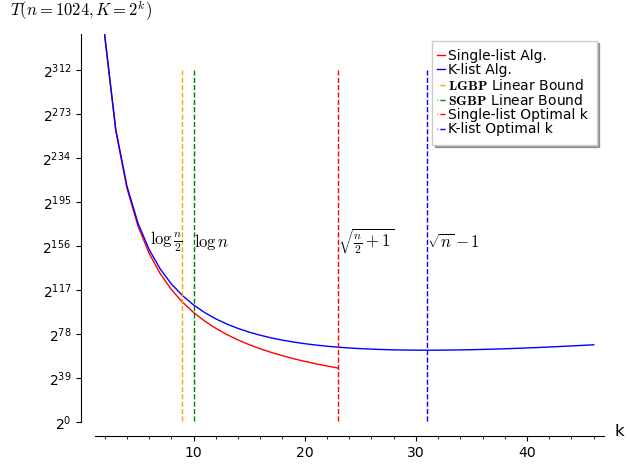

In [3]:
# plot summary of LGBP and SGBP

n = 1024
kmax1 = ceil(sqrt(n)) - 1 + 15
kmax2 = ceil(sqrt(n/2 + 1))
start = 2

lgbp_info_theory_bound = [(k, lgbp_lower_bound(n, k)) for k in range(start, kmax1 + 1)]
sgbp_info_theory_bound = [(k, sgbp_lower_bound(n,k)) for k in range(start, kmax1 + 1)]

k_list_alg_t = [(k, k_list_time_estimator(n,k)) for k in range(start, kmax1 + 1)]
single_list_alg_t = [(k, single_list_time_estimator(n,k)) for k in range(start, kmax2 + 1)]

k_list_time_line = list_plot_semilogy(k_list_alg_t, plotjoined=True, base = 2, 
                                  axes_labels=[r'k', r'$T(n = 1024, K = 2^k)$'],
                                  color='blue', legend_label=r'K-list Alg.', axes_labels_size=1.2)

single_list_time_line = list_plot_semilogy(single_list_alg_t, plotjoined=True, base = 2, 
                                    axes_labels=[r'k', r'$T(n = 1024, K = 2^k)$'],
                                   color='red', legend_label=r'Single-list Alg.', axes_labels_size=1.2)

# lgbp_info_theory_line = list_plot_semilogy(lgbp_info_theory_bound, plotjoined=True, base = 2, 
#                                     axes_labels=[r'k', r'$T(n = 1024, K = 2^k)$'],
#                                    color='orange', legend_label=r'$\mathbf{LGBP}$ Lower Bound', axes_labels_size=1.2)

# sgbp_info_theory_line = list_plot_semilogy(sgbp_info_theory_bound, plotjoined=True, base = 2, 
#                                     axes_labels=[r'k', r'$T(n = 1024, K = 2^k)$'],
#                                    color='green', legend_label=r'$\mathbf{SGBP}$ Lower Bound', axes_labels_size=1.2)

log_n_half = RR(log(n/2, 2))

lgbp_linear_line = line([(log_n_half, 2**1), (log_n_half, 2**312)], color='orange', linestyle='--', legend_label=r'$\mathbf{LGBP}$ Linear Bound')
lgbp_linear_label = text(r'$\log \frac{n}{2}$', (log_n_half, 2^160), color='black', fontsize=12, horizontal_alignment='right')

log_n = RR(log(n, 2))
sgbp_linear_line = line([(log_n, 2**1), (log_n, 2**312)], color='green', linestyle='--', legend_label=r'$\mathbf{SGBP}$ Linear Bound')
sgbp_linear_label = text(r'$\log n$', (log_n, 2^160), color='black', fontsize=12, horizontal_alignment='left')

single_list_optimal_k = ceil(sqrt(n/2 + 1))
single_op_k_line = line([(single_list_optimal_k, 2**1), (single_list_optimal_k, 2**312)], color='red', linestyle='--', legend_label=r'Single-list Optimal k')
single_op_k_label = text(r'$\sqrt{\frac{n}{2} + 1}$', (single_list_optimal_k, 2^160), color='black', fontsize=12, horizontal_alignment='left')

k_list_optimal_k = sqrt(n) - 1
k_op_k_line = line([(k_list_optimal_k, 2**1), (k_list_optimal_k, 2**312)], color='blue', linestyle='--', legend_label=r'K-list Optimal k')
k_op_k_label = text(r'$\sqrt{n} - 1$', (k_list_optimal_k, 2^160), color='black', fontsize=12, horizontal_alignment='left')

T_compare = single_list_time_line + k_list_time_line
linear_bounds = lgbp_linear_line + lgbp_linear_label + sgbp_linear_line + sgbp_linear_label
optimal_k = single_op_k_line + single_op_k_label + k_op_k_line + k_op_k_label
Final = T_compare + linear_bounds + optimal_k
# Final.save_image("./gbp-summary.eps")
Final.show()